The estimation of Feature Importance based on a Linear Regression model.

Analyzing the most important features in the input dataframe with respect to a simple linear regression model. 
For this reason, first all the highly correlated features were dropped according to result of VIF and 
then regression model was applied to estimate the importance of each remaining features.


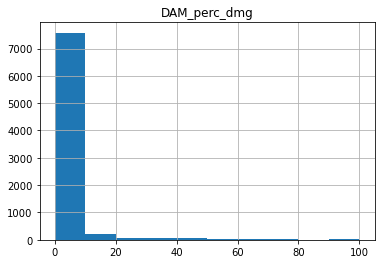

In [1]:
#%load_ext autoreload
#%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import random
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import os
from sklearn.feature_selection import RFECV
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, max_error
import numpy as np
from numpy.lib.function_base import average
import pandas as pd
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import importlib
import os
from sklearn.feature_selection import (
    SelectKBest,
    RFE,
    mutual_info_regression,
    f_regression,
    mutual_info_classif,
)
from sklearn.preprocessing import RobustScaler
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import xgboost as xgb
import random
import pickle
import openpyxl
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import pickle
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#import geopandas as gpd
import importlib


wor_dir="/home/mforooshani/Typhoon-Impact-based-forecasting-model-training-5:7/IBF-Typhoon-model/"
os.chdir(wor_dir)
cdir = os.getcwd()

combined_input_data=pd.read_csv("Training-data-new/data/model_input/combined_input_data.csv")

typhoons_with_impact_data=['bopha2012', 'conson2010', 'durian2006', 'fengshen2008',
       'fung-wong2014', 'goni2015', 'goni2020', 'hagupit2014',
       'haima2016', 'haiyan2013', 'jangmi2014', 'kalmaegi2014',
       'kammuri2019', 'ketsana2009', 'koppu2015', 'krosa2013',
       'linfa2015', 'lingling2014', 'mangkhut2018', 'mekkhala2015',
       'melor2015', 'meranti2016', 'molave2020', 'mujigae2015',
       'nakri2019', 'nari2013', 'nesat2011', 'nock-ten2016', 'noul2015',
       'phanfone2019', 'rammasun2014', 'sarika2016', 'saudel2020',
       'tokage2016', 'trami2013', 'usagi2013', 'utor2013', 'vamco2020',
       'vongfong2020', 'yutu2018']

len(np.unique(combined_input_data.typhoon))
combined_input_data=combined_input_data[combined_input_data.typhoon.isin(typhoons_with_impact_data)]


def set_zeros(x):
    x_max = 25
    y_max = 50
    
    v_max = x[0]
    rainfall_max = x[1]
    damage = x[2]
    if pd.notnull(damage):
        value = damage
    elif v_max > x_max or rainfall_max > y_max:
        value =damage
    elif (v_max < np.sqrt((1- (rainfall_max**2/y_max ** 2))*x_max ** 2)):
        value = 0
    else:
        value = np.nan

    return value
combined_input_data["DAM_perc_dmg"] = combined_input_data[["HAZ_v_max", "HAZ_rainfall_Total", "DAM_perc_dmg"]].apply(set_zeros, axis="columns")


np.mean(combined_input_data["DAM_perc_dmg"])
combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
np.mean(combined_input_data["DAM_perc_dmg"])
np.unique(combined_input_data.typhoon)

def cubeic(x):
    #x=float(x)
    value=x*x*x
    return value

combined_input_data['HAZ_v_max_3']=combined_input_data['HAZ_v_max'].apply(lambda x: x*x*x) 
#display(combined_input_data)
combined_input_data.hist(column="DAM_perc_dmg") 

combined_input_data =combined_input_data.filter(['typhoon','HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary', 
        'DAM_perc_dmg'])


features_name = combined_input_data.columns
#display(features_name)

#All the highly correlated features were removed from X data.
features =['HAZ_rainfall_Total', 
        'HAZ_v_max',
        'GEN_landslide_per',
        'GEN_stormsurge_per', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg',  
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall']


df=combined_input_data.dropna()
#display(df)



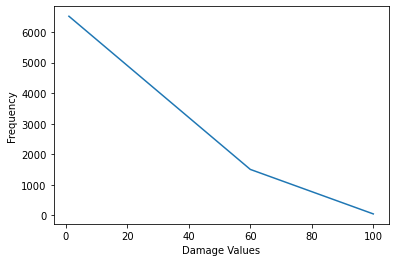

In [2]:
#A bin's set defined to categorize target values in different groups(bins)
#The chosen bins
bins2= [0, 1, 60, 100]
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

In [3]:
#Display bins
print(samples_per_bin2)
print(binsP2)

[6517 1506   50]
[  0   1  60 100]


In [4]:
bin_index2=np.digitize(df['DAM_perc_dmg'], bins=binsP2)

In [5]:
y_input_strat=bin_index2

In [6]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statistics

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)


# Split dataset into training set and test set and applying data stratification according to the defined bins
X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, test_size=0.2)

    

Index(['HAZ_rainfall_Total', 'HAZ_v_max', 'GEN_landslide_per',
       'GEN_stormsurge_per', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg',
       'GEN_OR_per_SSAbldg', 'GEN_Yellow_per_LSbl', 'TOP_mean_slope',
       'GEN_with_coast', 'GEN_coast_length', 'VUL_Housing_Units',
       'VUL_StrongRoof_StrongWall', 'VUL_StrongRoof_SalvageWall',
       'VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall',
       'VUL_LightRoof_SalvageWall', 'VUL_SalvagedRoof_StrongWall',
       'VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall'],
      dtype='object')

In [7]:
from sklearn.linear_model import LinearRegression
import shap
regressor = LinearRegression()
model_regr=regressor.fit(X_train, y_train)

In [8]:
feature=[]
values=[]
importance = regressor.coef_
#print(importance)
for i,j in enumerate(importance):
    print('Feature %0d ' %(i) + X.columns[i]+':, Score: %.5f' % (j))
    
    feature.append(X.columns[i])
    values.append(j)
        

Feature 0 HAZ_rainfall_Total:, Score: -0.51791
Feature 1 HAZ_v_max:, Score: 4.49816
Feature 2 GEN_landslide_per:, Score: -0.31408
Feature 3 GEN_stormsurge_per:, Score: 0.34088
Feature 4 GEN_Red_per_LSbldg:, Score: 0.29785
Feature 5 GEN_Or_per_LSblg:, Score: -0.05802
Feature 6 GEN_OR_per_SSAbldg:, Score: -0.19095
Feature 7 GEN_Yellow_per_LSbl:, Score: -0.07194
Feature 8 TOP_mean_slope:, Score: -0.46723
Feature 9 GEN_with_coast:, Score: 0.27980
Feature 10 GEN_coast_length:, Score: -0.30389
Feature 11 VUL_Housing_Units:, Score: -0.14686
Feature 12 VUL_StrongRoof_StrongWall:, Score: -0.78577
Feature 13 VUL_StrongRoof_SalvageWall:, Score: 0.59604
Feature 14 VUL_LightRoof_StrongWall:, Score: 0.31613
Feature 15 VUL_LightRoof_LightWall:, Score: -0.12919
Feature 16 VUL_LightRoof_SalvageWall:, Score: 0.18541
Feature 17 VUL_SalvagedRoof_StrongWall:, Score: -0.13122
Feature 18 VUL_SalvagedRoof_LightWall:, Score: 0.22065
Feature 19 VUL_SalvagedRoof_SalvageWall:, Score: 0.26368


In [9]:
#Creating a dataframe of features and their coefficient values 

df_coef=pd.DataFrame(columns = ['feature', 'coef_value'])
df_coef['feature']= feature
df_coef['coef_value']= values

df_coef

,feature,coef_value
0,HAZ_rainfall_Total,-0.517909
1,HAZ_v_max,4.498159
2,GEN_landslide_per,-0.314085
3,GEN_stormsurge_per,0.340877
4,GEN_Red_per_LSbldg,0.297851
5,GEN_Or_per_LSblg,-0.058020
6,GEN_OR_per_SSAbldg,-0.190954
7,GEN_Yellow_per_LSbl,-0.071936
8,TOP_mean_slope,-0.467234
9,GEN_with_coast,0.279795


In [10]:
#Sorting the dataframe of coefficient values in a descending order

final_sorted_df = df_coef.sort_values(by=['coef_value'], ascending=False)
final_sorted_df=final_sorted_df.reset_index(drop=True)
final_sorted_df

,feature,coef_value
0,HAZ_v_max,4.498159
1,VUL_StrongRoof_SalvageWall,0.596041
2,GEN_stormsurge_per,0.340877
3,VUL_LightRoof_StrongWall,0.316131
4,GEN_Red_per_LSbldg,0.297851
5,GEN_with_coast,0.279795
6,VUL_SalvagedRoof_SalvageWall,0.263683
7,VUL_SalvagedRoof_LightWall,0.220649
8,VUL_LightRoof_SalvageWall,0.185414
9,GEN_Or_per_LSblg,-0.058020


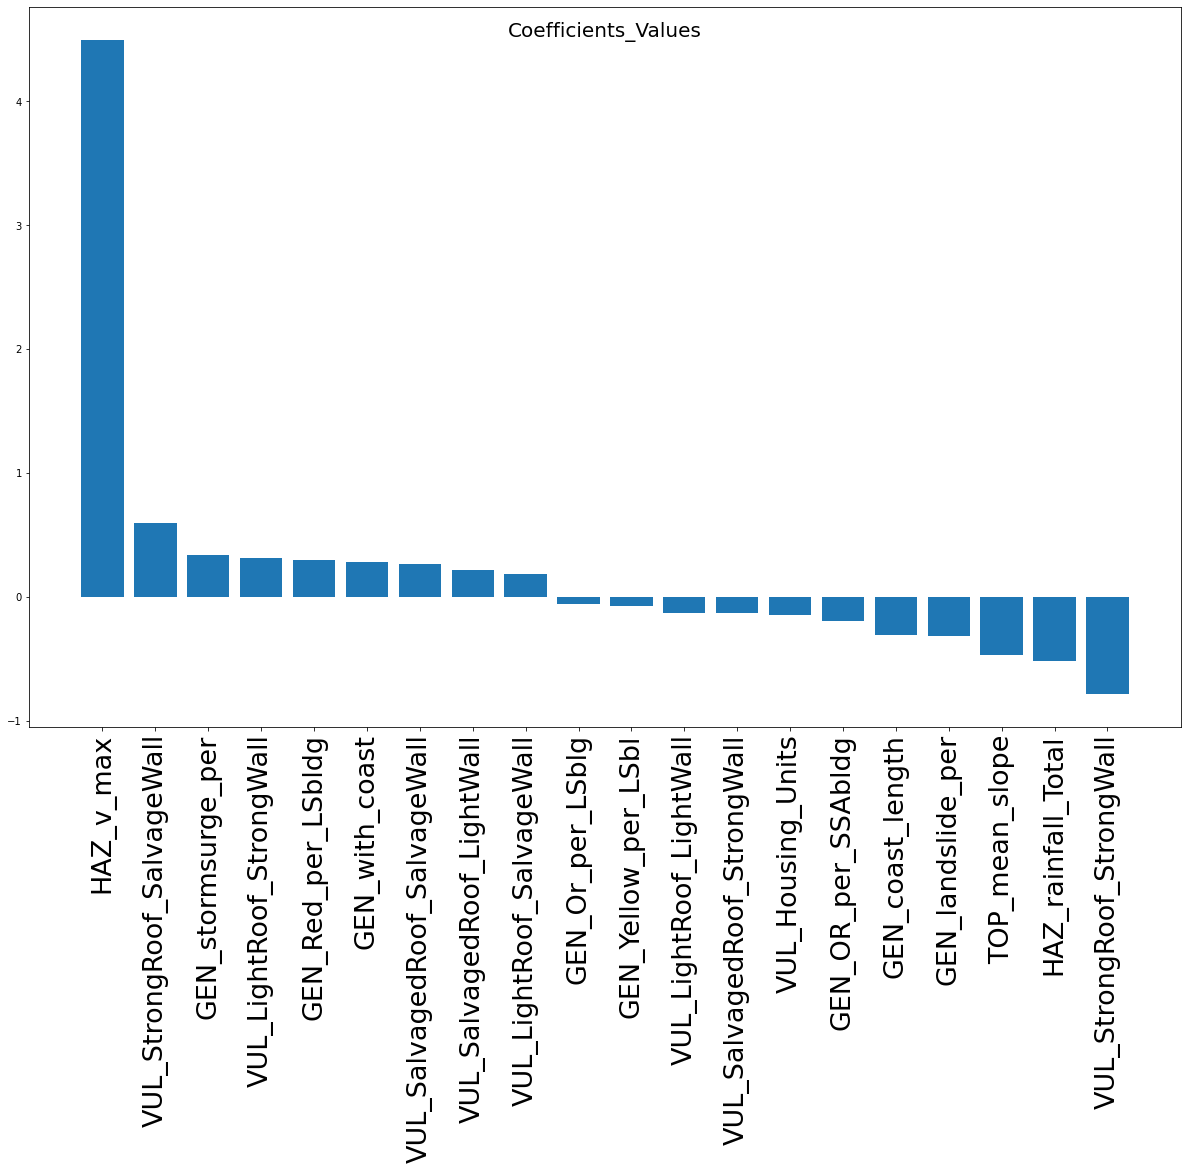

In [11]:
fig = plt.figure(figsize=(16,10))
fig.suptitle("Coefficients_Values", fontsize=20)
ax = fig.add_axes([0,0,1,1])
#ax.bar(features,values)
ax.bar(final_sorted_df['feature'],final_sorted_df['coef_value'])
np.rot90(plt.xticks(rotation=90, fontsize=27))
plt.show()

In [12]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     115.7
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:58:28   Log-Likelihood:                -22494.
No. Observations:                6458   AIC:                         4.503e+04
Df Residuals:                    6437   BIC:                         4.517e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4485      0.098     24.926      0.0

In [13]:
fea = X.columns
fea.tolist()
fea_1=pd.DataFrame(columns=['names'])
fea_1['names']=fea.tolist()
fea_1

,names
0,HAZ_rainfall_Total
1,HAZ_v_max
2,GEN_landslide_per
3,GEN_stormsurge_per
4,GEN_Red_per_LSbldg
5,GEN_Or_per_LSblg
6,GEN_OR_per_SSAbldg
7,GEN_Yellow_per_LSbl
8,TOP_mean_slope
9,GEN_with_coast
